# Experiment with UNet Training

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from rattlinbog.estimators.apply import apply
from rattlinbog.estimators.wetland_classifier import WetlandClassifier
from rattlinbog.th_extensions.utils.dataset_splitters import GROUND_TRUTH_KEY, \
    PARAMS_KEY
from rattlinbog.train_cnn import OPEN_WATER_MEAN_BSC

RESAMPLE = False

## Data Investigation

In [2]:
valid_ds = xr.open_zarr(
    "/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E045N018T3/SIG0-HPAR-MASK-CORINE-BOGS-MARSHES_20170101T000000_20180101T000000__CORINE-BOGS-MARSHES-ROI-0-0-15000-15000_E045N018T3_EU020M__.zarr")
param_selection = ['SIG0-HPAR-PHS', 'SIG0-HPAR-AMP', 'SIG0-HPAR-M0']
valid_ds = valid_ds.sel(parameter=param_selection)

In [3]:
# y=slice(2400000, 2300000), x=slice(4837000, 4937000)north germany
# y=slice(1300000, 1200000), x=slice(6200000, 6300000) danube delta
# y=slice(2278499, 2222569), x=slice(5158533, 5238132) # north germany - more
# 4532072,1962529, 4607958,2018510 rheinland flooded area
# valid_selection = valid_ds.sel(y=slice(2000000, 1900000), x=slice(4500000, 4600000))
valid_selection = valid_ds.sel(y=slice(2060000, 1960000), x=slice(4510000, 4610000))
valid_selection

<xarray.Dataset>
Dimensions:       (y: 5000, x: 5000, parameter: 3)
Coordinates:
    band          int64 ...
  * parameter     (parameter) <U14 'SIG0-HPAR-PHS' ... 'SIG0-HPAR-M0'
  * x             (x) float64 4.51e+06 4.51e+06 4.51e+06 ... 4.61e+06 4.61e+06
  * y             (y) float64 2.06e+06 2.06e+06 2.06e+06 ... 1.96e+06 1.96e+06
Data variables:
    ground_truth  (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    params        (parameter, y, x) float32 dask.array<chunksize=(3, 500, 500), meta=np.ndarray>
    spatial_ref   int64 ...

In [23]:
valid_ds = valid_ds.load()

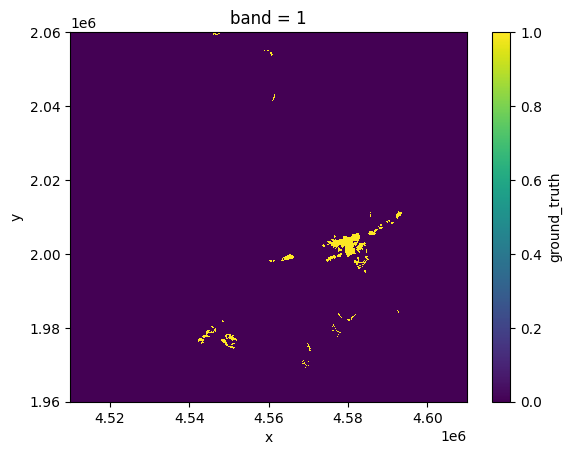

In [24]:
valid_selection[GROUND_TRUTH_KEY].plot.imshow()

## Test Model

### hparam model test

In [2]:
test_ds = xr.open_zarr(
    "/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E060N012T3/SIG0-HPAR-MASK-CORINE-BOGS-MARSHES_20170101T000000_20180101T000000__CORINE-BOGS-MARSHES-ROI-0-0-15000-15000_E060N012T3_EU020M__.zarr")
param_selection = ['SIG0-HPAR-PHS', 'SIG0-HPAR-AMP', 'SIG0-HPAR-M0']
test_ds = test_ds.sel(parameter=param_selection)

In [3]:
test_ds = test_ds.sel(y=slice(1300000, 1200000), x=slice(6200000, 6300000))
# test_ds = test_ds.sel(y=slice(2400000, 2300000), x=slice(4840000, 4940000))
# test_ds = test_ds.sel(y=slice(2280000, 2220000), x=slice(5150000, 5240000))
# test_ds = test_ds.sel(y=slice(2060000, 1960000), x=slice(4510000, 4610000))
test_ds

<xarray.Dataset>
Dimensions:       (y: 5000, x: 5000, parameter: 3)
Coordinates:
    band          int64 ...
  * parameter     (parameter) <U14 'SIG0-HPAR-PHS' ... 'SIG0-HPAR-M0'
  * x             (x) float64 6.2e+06 6.2e+06 6.2e+06 ... 6.3e+06 6.3e+06
  * y             (y) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.2e+06 1.2e+06
Data variables:
    ground_truth  (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    params        (parameter, y, x) float32 dask.array<chunksize=(3, 500, 500), meta=np.ndarray>
    spatial_ref   int64 ...

In [4]:
def normalize(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val)


def preprocess_rgb_comp(x):
    o = x.copy()
    o[0, ...] = normalize(x[0], -np.pi, np.pi)
    o[1, ...] = normalize(np.clip((10 ** (x[1] / 10.0)), 1, 1.5), 1.0, 1.5)
    o[2, ...] = normalize(np.clip(x[2], -25, -8), -25, -8)
    return o


test_ds[PARAMS_KEY] = test_ds[PARAMS_KEY].map_blocks(preprocess_rgb_comp, template=test_ds[PARAMS_KEY])

In [5]:
test_ds = test_ds.persist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


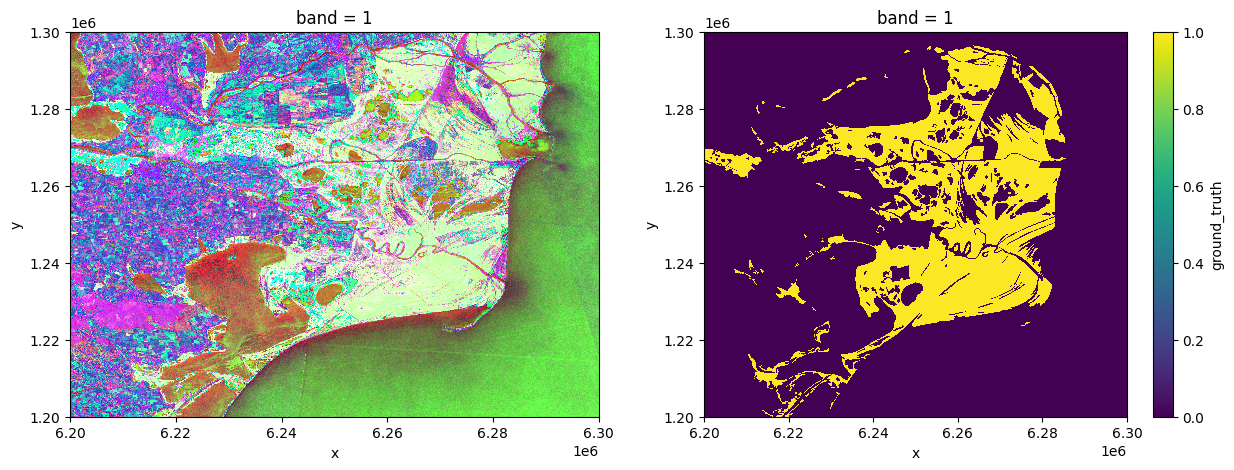

In [6]:
_, axes = plt.subplots(ncols=2, figsize=(15, 5))
test_ds[PARAMS_KEY].plot.imshow(ax=axes[0])
test_ds[GROUND_TRUTH_KEY].plot(ax=axes[1])
plt.draw()

#### Load and test model

In [6]:
estimator = WetlandClassifier.from_snapshot(
    Path('/data/wetland/models/hparam/CORINE-BOGS-MARSHES/2023-05-31_06-37-10/WetlandClassifier-F1-best.pt'), batch_size=16)

In [7]:
estimate = apply(estimator).to(test_ds['params'])

In [8]:
estimate = estimate.load()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


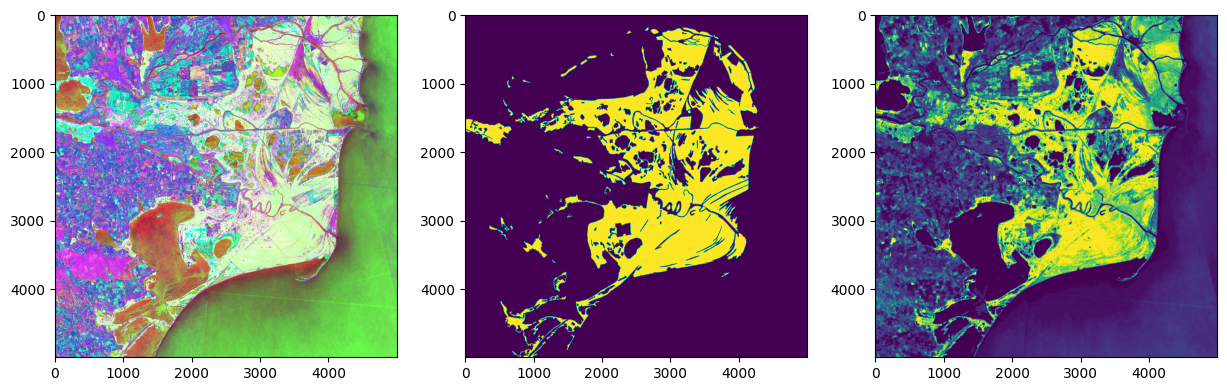

In [9]:
_, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(test_ds[PARAMS_KEY].values.transpose((1, 2, 0)))
axes[1].imshow(test_ds[GROUND_TRUTH_KEY])
axes[2].imshow(estimate[0])
plt.draw()

In [10]:
scores = estimator.score_estimate(estimate.values, test_ds[GROUND_TRUTH_KEY].values)
scores

{'TPR': 0.8965433092849301,
 'TNR': 0.8779539080209032,
 'FPR': 0.12204609197909681,
 'FNR': 0.1034566907150699,
 'PPV': 0.66654885,
 'F1': 0.7646253,
 'BA': 0.8872486086529167}

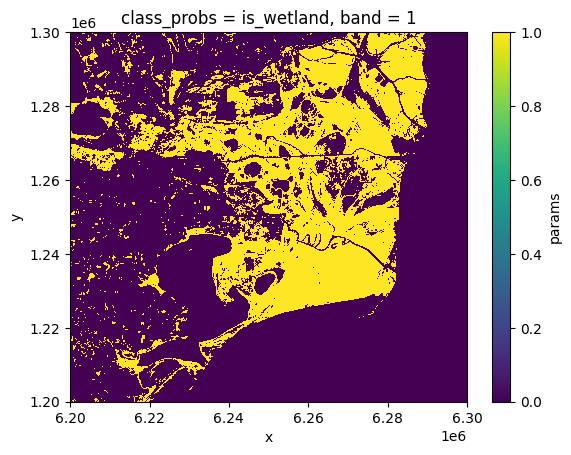

In [11]:
(estimate[0] > 0.5).plot.imshow()

In [11]:
estimate[0].rio.to_raster("/data/wetland/hparam_model_CCI_2017-2018_valid_danube_2017-2018_CORINE_estimate.tif", compress='ZSTD')
test_ds[GROUND_TRUTH_KEY].astype('uint8').rio.to_raster("/data/wetland/hparam_model_CCI_2019-2021_valid_danube_2017-2018_CORINE.tif", compress='ZSTD')
test_ds[PARAMS_KEY].rio.to_raster("/data/wetland/hparam_model_CCI_2017-2018_valid_danube_2017-2018_CORINE__params.tif", compress='ZSTD')

### mmeans model test

In [29]:
# test_ds = xr.open_zarr(
#     "/data/wetland/mmean/V1M0R1/EQUI7_EU020M/E060N012T3/MEAN-SIG0-MONTH-MASK____CORINE-INLAND-MARSHES-ROI-0-0-15000-15000_E060N012T3_EU020M__.zarr")
test_ds = xr.open_zarr(
    "/data/wetland/mmean/V1M0R1/EQUI7_EU020M/E060N012T3/MEAN-SIG0-MONTH-MASK-CCI_20200101T000000_20200101T000000__2020-ROI-0-0-15000-15000_E060N012T3_EU020M__.zarr")
test_ds = test_ds.isel(parameter=slice(0, 12))

In [30]:
test_ds = test_ds.sel(y=slice(1300000, 1200000), x=slice(6200000, 6300000))
# test_ds = test_ds.sel(y=slice(2280000, 2220000), x=slice(5150000, 5240000))
# test_ds = test_ds.sel(y=slice(2060000, 1960000), x=slice(4510000, 4610000))
# test_ds = test_ds.sel(y=slice(2260000, 2240000), x=slice(4620000, 4640000))

In [31]:
def preprocess_sig0(x):
    return x.fillna(OPEN_WATER_MEAN_BSC)


test_ds[PARAMS_KEY] = test_ds[PARAMS_KEY].map_blocks(preprocess_sig0, template=test_ds[PARAMS_KEY])

In [32]:
test_ds = test_ds.persist()

In [6]:
estimator = WetlandClassifier.from_snapshot(
    Path('/data/wetland/models/mmean/CCI/20180101-20180101/2023-05-28_16-45-53/WetlandClassifier-F1-best.pt'), batch_size=16)

In [33]:
estimate = apply(estimator).to(test_ds['params'])

In [34]:
estimate = estimate.load()

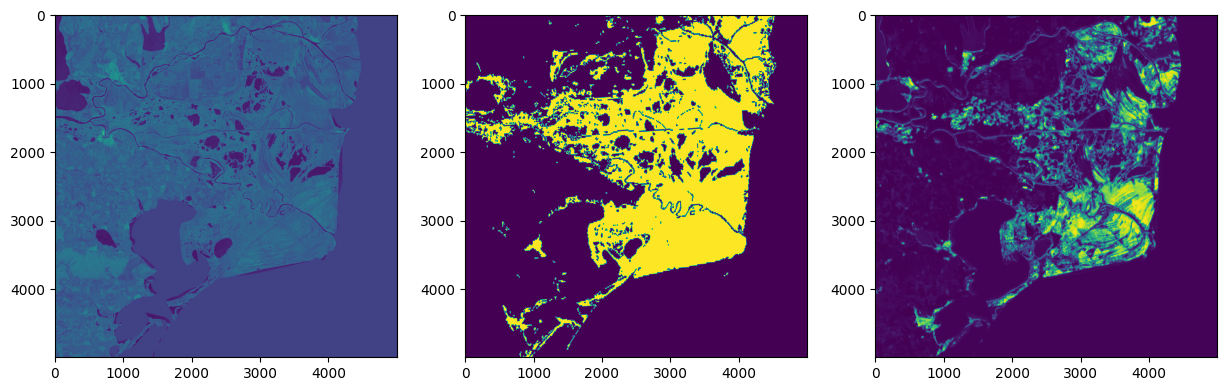

In [35]:
_, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(test_ds[PARAMS_KEY][0].values)
axes[1].imshow(test_ds[GROUND_TRUTH_KEY])
axes[2].imshow(estimate[0])
plt.draw()

In [19]:
scores = estimator.score_estimate(estimate.values, test_ds[GROUND_TRUTH_KEY].values)
scores

{'TPR': 0.6185891208666476,
 'TNR': 0.9320097334089885,
 'FPR': 0.06799026659101146,
 'FNR': 0.3814108791333524,
 'PPV': 0.7122928,
 'F1': 0.6621423,
 'BA': 0.7752994271378181}

In [11]:
estimate[0].rio.to_raster("/data/wetland/mmean_model_CCI_2018_valid_danube_2018_CORINE_estimate.tif", compress='ZSTD')
test_ds[GROUND_TRUTH_KEY].astype('uint8').rio.to_raster("/data/wetland/mmean_model_CCI_2018_valid_danube_2018_CORINE_gt.tif", compress='ZSTD')
test_ds[PARAMS_KEY].rio.to_raster("/data/wetland/mmean_model_CCI_2018_valid_danube_2018_CORINE_params.tif", compress='ZSTD')

## Export Estimates

In [12]:
valid_estimate = estimate.rio.write_transform(valid_ds[GROUND_TRUTH_KEY].rio.transform())
valid_estimate = valid_estimate.rio.write_crs(valid_ds.spatial_ref.attrs['crs_wkt'])
valid_estimate = valid_estimate.where(valid_estimate > 0.1, 0)
valid_estimate.rio.write_nodata(0, inplace=True)
valid_estimate[0].rio.to_raster("/tmp/valid-estimate.tif")

In [14]:
estimate_train = apply(estimator).to(train_ds['params'])

In [15]:
train_estimate = estimate_train.rio.write_transform(train_ds[GROUND_TRUTH_KEY].rio.transform())
train_estimate = train_estimate.rio.write_crs(train_ds.spatial_ref.attrs['crs_wkt']).load()

In [47]:
train_estimate_mask = train_estimate.where(train_estimate > 0.1, 0)
train_estimate_mask = train_estimate_mask.rio.set_encoding(dict(dtype='uint8', _FillValue=255))
train_estimate_mask[0].rio.to_raster("/tmp/train-estimate-mask.tif", compress='ZSTD')

In [16]:
train_estimate_prob = train_estimate.rio.set_encoding(dict(scale_factor=0.01, dtype='int8', _FillValue=127))
train_estimate_prob[0].rio.to_raster("/tmp/train-estimate-prob-incomplete.tif", compress='ZSTD')

In [19]:
train_ds[GROUND_TRUTH_KEY].rio.to_raster("/tmp/train-mask-incomplete.tif", compress='ZSTD')

In [24]:
wetland_rgb_ds = wetland_ds[PARAMS_KEY].map_blocks(preprocess_rgb_comp, template=wetland_ds[PARAMS_KEY])

In [26]:
wetland_rgb_out = wetland_rgb_ds.rio.write_transform(wetland_ds[GROUND_TRUTH_KEY].rio.transform())
wetland_rgb_out = wetland_rgb_out.rio.write_crs(wetland_ds.spatial_ref.attrs['crs_wkt'])
wetland_rgb_out = wetland_rgb_out.rio.set_encoding(dict(scale_factor=0.01, dtype='uint8', _FillValue=255))
wetland_rgb_out.rio.to_raster('/tmp/rgb-composite.tif', compress='ZSTD')

In [16]:
estimate_all = apply(estimator).to(wetland_rgb_ds)

In [17]:
estimate_all = estimate_all.rio.write_crs(wetland_ds.spatial_ref.attrs['crs_wkt'])
estimate_all = estimate_all.where(estimate_all > 0.1, 0)
estimate_all.rio.write_nodata(0, inplace=True)
estimate_all[0].rio.to_raster("/tmp/all-estimate.tif")